In [165]:
import sys

sys.path.append("../1")

import compare_benchmarks

from matplotlib import pyplot
from functools import cmp_to_key
from statistics import geometric_mean

In [137]:
testList = []
with open("../2/tests.txt") as testsListFile:
    testList = testsListFile.readlines()
    testList = [test.rstrip() for test in testList]
print(testList)

['base_perftests', 'blink_heap_perftests', 'blink_platform_perftests', 'cc_perftests', 'components_perftests', 'dawn_perf_tests', 'load_library_perf_tests', 'net_perftests', 'browser_tests', 'services_perftests', 'tracing_perftests', 'views_perftests', 'viz_perftests']


In [138]:
testsMapping = {}
for test in testList:
    testsMapping[test] = []
    for i in range(1,6):
        testsMapping[test].append(test + "." + str(i) + ".json")

In [139]:
loadedTestMapping = {}
for test in testsMapping:
    loadedTestMapping[test] = []
    for testInstance in testsMapping[test]:
        loadedTestMapping[test].append(compare_benchmarks.load_benchmarks("./test-output/" + testInstance))

In [140]:
loadTestComparisons = {}
for test in loadedTestMapping:
    loadTestComparisons[test] = []
    for testInstance in loadedTestMapping[test][1:]:
        loadTestComparisons[test].append(compare_benchmarks.per_test_comparison(loadedTestMapping[test][0], testInstance))

In [141]:
testComparisonsAverages = {}
for test in loadTestComparisons:
    testComparisonsAverages[test] = []
    for testInstance in loadTestComparisons[test]:
        testComparisonsAverages[test].append(compare_benchmarks.get_average_speedup(testInstance))

In [142]:
print(testComparisonsAverages.keys())

dict_keys(['base_perftests', 'blink_heap_perftests', 'blink_platform_perftests', 'cc_perftests', 'components_perftests', 'dawn_perf_tests', 'load_library_perf_tests', 'net_perftests', 'browser_tests', 'services_perftests', 'tracing_perftests', 'views_perftests', 'viz_perftests'])


{'mem_uops_retired.all_loads': [0.9980638499189474, 0.9985941784343744, 1.0112718982778637, 0.9993908925242614], 'mem_uops_retired.all_stores': [0.9986492328622771, 1.0042418814534348, 1.0064565970817587, 1.0025243617365724]}


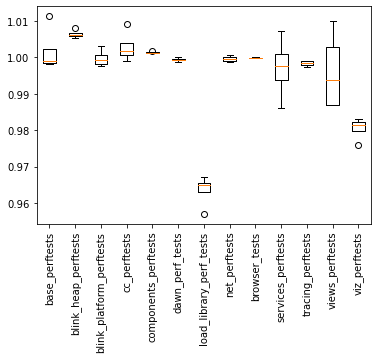

In [143]:
allTestMetrics = {}
for test in testComparisonsAverages:
    allTestMetrics[test] = {}
    for testInstance in testComparisonsAverages[test]:
        for metric in testInstance:
            if metric not in allTestMetrics[test]:
                allTestMetrics[test][metric] = []
            allTestMetrics[test][metric].append(testInstance[metric])
print(allTestMetrics["base_perftests"])
LoadMetrics = {}
for test in allTestMetrics:
    LoadMetrics[test] = allTestMetrics[test]["mem_uops_retired.all_loads"]
figure, axis = pyplot.subplots()
axis.boxplot(LoadMetrics.values())
axis.set_xticklabels(LoadMetrics.keys())
pyplot.xticks(rotation=90)
pyplot.show()

# Initial Impressions

Eliminating some test suites from this point will probably be easy for composing a good benchmarking pipeline. Suites like `load_library_perf_tests` are showing nothing even close to reliable performance, and I don't think I would really expect them to even just given the name. They're probably not CPU bound and instead testing performance on IO and what not which is not the point of these tests. Other test suites seem to be good candidates though like `base_perftests`, `blink_platform_perftests`, `cc_perftests`, `component_perftests`, `dawn_perf_tests`, `net_perftests` (although I need to dig into this one and see if it is testing CPU bound networking code with actually networking mocked out or if it is actually calling network stuff, but I would assume the former), `browser_tests`, and `tracing_perftests`.

There is also some more data needed on what would happen if we're able to remove a lot of the really noisy tests that aren't necessarily CPU bound. The rest of this notebook will probably be used to do analysis on that sort of stuff.

In [144]:
allTestRanges = {}
for testSuite in loadTestComparisons:
    testRanges = {}
    for testRun in loadTestComparisons[testSuite]:
        for test in testRun:
            if test not in testRanges:
                testRanges[test] = {}
            for metric in testRun[test]:
                if metric not in testRanges[test]:
                    testRanges[test][metric] = []
                testRanges[test][metric].append(testRun[test][metric])
    allTestRanges[testSuite] = testRanges

In [178]:
testSuiteIndividualAnalysis = "base_perftests"
individualTestsLoads = {}
individualTestsStores = {}
for test in allTestRanges[testSuiteIndividualAnalysis]:
    individualTestsLoads[test] = allTestRanges[testSuiteIndividualAnalysis][test]["mem_uops_retired.all_loads"]
    individualTestsStores[test] = allTestRanges[testSuiteIndividualAnalysis][test]["mem_uops_retired.all_stores"]

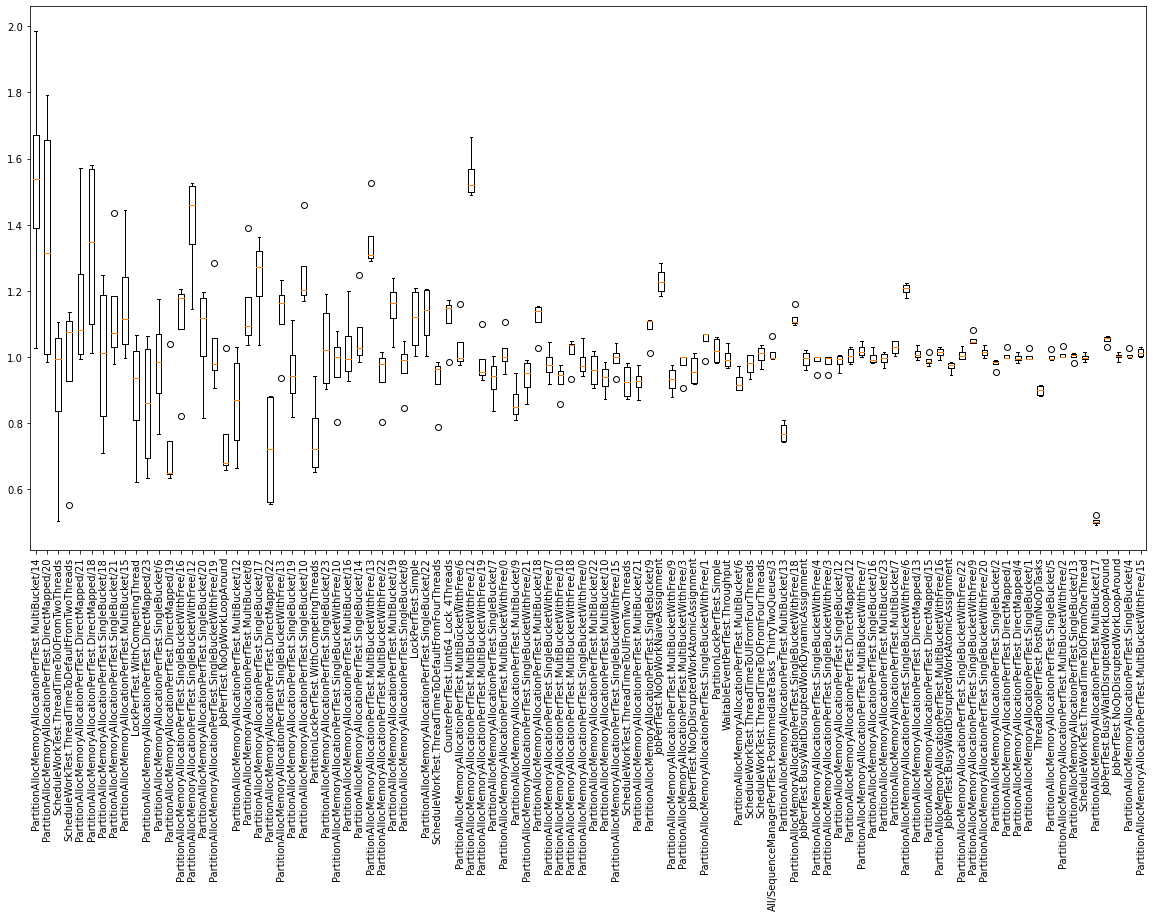

In [179]:
def rangeCompare(a,b):
    if (max(b[1]) - min(b[1])) > (max(a[1]) - min(a[1])):
        return -1
    return 1

sortedIndividualTestsLoads = sorted(individualTestsLoads.items(), key=cmp_to_key(rangeCompare), reverse=True)

outputIndividualTestsLoads = {}
for parts in sortedIndividualTestsLoads:
    outputIndividualTestsLoads[parts[0]] = parts[1]

displayPartition = {}
for test in outputIndividualTestsLoads:
    displayPartition[test] = outputIndividualTestsLoads[test]
    if len(displayPartition) == 100:
        break
figure, axis = pyplot.subplots()
axis.boxplot(displayPartition.values())
axis.set_xticklabels(displayPartition.keys())
figure.set_size_inches(20, 10)
pyplot.xticks(rotation=90)
pyplot.show()

A lot of the variability seems to be coming from just a few tests within these test suites. Next up I'm going to try cutting off the 10% of tests with the highest range and see how that impacts the overall performance of at least one of the test suites (probably the `base_perftests` suite and if I end up going in this direction, the other candidate test suites as well).

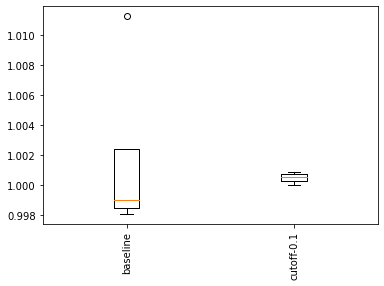

[1.0008326905807108, 1.0006632109647275, 0.9999902873196946, 1.0003283784537211]


In [184]:
loadTestsCutoff = {}
counter = 0
for parts in sortedIndividualTestsLoads:
    if counter > 0.4 * len(sortedIndividualTestsLoads):
        loadTestsCutoff[parts[0]] = parts[1]
    counter += 1

runRelativeSpeedups = []
for test in loadTestsCutoff:
    for index,speedupValue in enumerate(loadTestsCutoff[test]):
        if index + 1 > len(runRelativeSpeedups):
            runRelativeSpeedups.append([])
        runRelativeSpeedups[index].append(speedupValue)

speedupsGeometricMeans = []
for speedupArray in runRelativeSpeedups:
    speedupsGeometricMeans.append(geometric_mean(speedupArray))

cutoffTestingPlotDict = {
    "baseline": allTestMetrics[testSuiteIndividualAnalysis]["mem_uops_retired.all_loads"],
    "cutoff-0.1": speedupsGeometricMeans
}

figure, axis = pyplot.subplots()
axis.boxplot(cutoffTestingPlotDict.values())
axis.set_xticklabels(cutoffTestingPlotDict.keys())
pyplot.xticks(rotation=90)
pyplot.show()

print(speedupsGeometricMeans)

Based on these results, cutting off the most variable tests definitely seems like it could be helpful. However, the threshold for different tests needs to be played around with a little bit. Some tests seem to benefit greatly from a pretty high threshold (eg `base_perftests` at 40%), while other tests don't seem to need that much cut off (eg `browser_perftests` that can still hit really low variability without any tests being cut off). Below is a list of tests that I'm planning on using along with the threshold that works well for that specific test:
```
base_perftests - 40%
```
Next up is to do a full comparison, comparing all of the selected test suites combined in regards to a baseline configuration and a filtered configuration with the x% of variable tests per suite taken out and ignored.